In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load Data

In [89]:
# Load the data
df_comments = pd.read_parquet('../data/clean_data/df_trans_sent_comments.parquet')
df_videos = pd.read_csv('../data/clean_data/df_video_data.csv')
df_channel = pd.read_csv('../data/clean_data/df_channel_data.csv')
df_categories = pd.read_csv('../data/clean_data/df_categories.csv')

# Feature Engineering of Numerical Data

Feature engineering for `df_comments`and `df_videos`:
* Comment Age

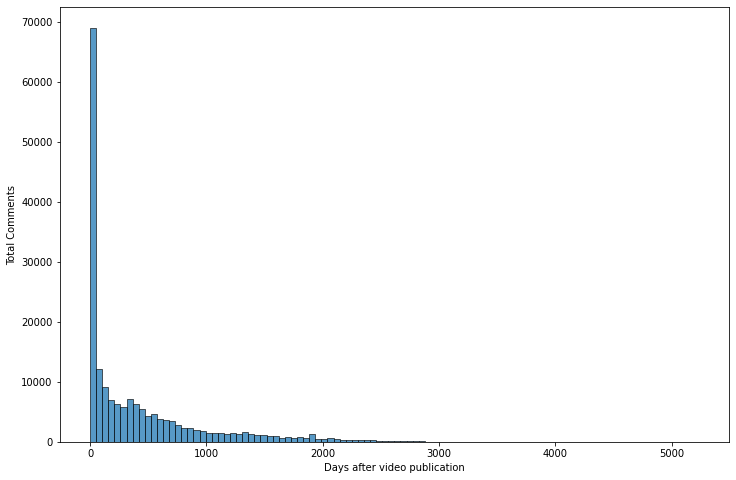

In [90]:
# Match name of column
df_videos.rename(columns={'videoId': 'video_id'}, inplace=True)
df_videos['publishedAt'] = pd.to_datetime(df_videos['publishedAt'])

# Merge both dataframes
df_merged = df_comments.merge(df_videos, on='video_id', how='left')

# Calculate comment's age
df_merged['comment_age_days'] = (df_merged['published_at'] - df_merged['publishedAt']).dt.days.values

# Comments before video realeased will be considered as '0 days'
df_merged['comment_age_days'] = df_merged['comment_age_days'].apply(lambda x: max(x, 0))

# Plot the result
plt.figure(figsize=(12,8))
sns.histplot(df_merged['comment_age_days'], bins=100)
plt.ylabel('Total Comments')
plt.xlabel('Days after video publication')
plt.show();

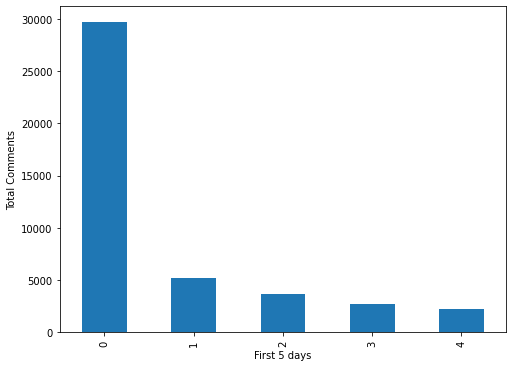

In [91]:
# Plot comments interaction firts days
plt.figure(figsize=(8, 6))
df_merged['comment_age_days'].value_counts()[:5].plot(kind='bar')
plt.xlabel('First 5 days')
plt.ylabel('Total Comments')
plt.show();

* Interation frequency

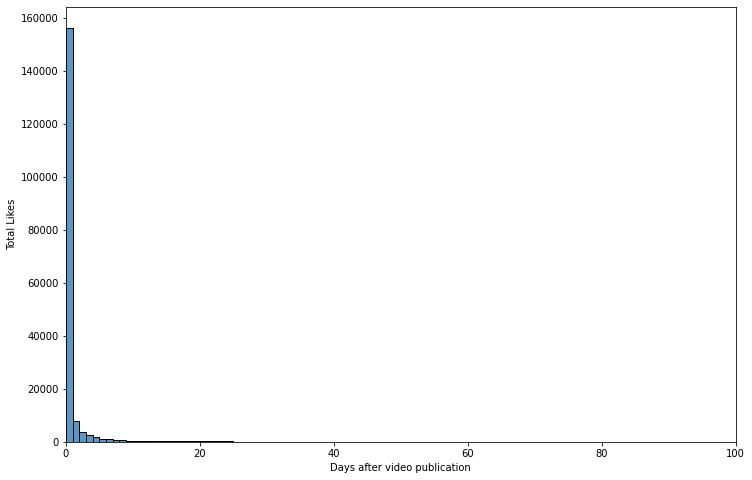

In [92]:
df_merged['likes_per_day'] = df_merged['like_count'] / df_merged['comment_age_days'].replace(0, 1)
df_merged['likes_per_day'].sort_values(ascending=False).head()

# Plot the result
plt.figure(figsize=(12,8))
sns.histplot(df_merged[df_merged['likes_per_day'] < 50]['likes_per_day'], bins=50)
plt.ylabel('Total Likes')
plt.xlabel('Days after video publication')
plt.xlim(0, 100)
plt.show();

* Date Age

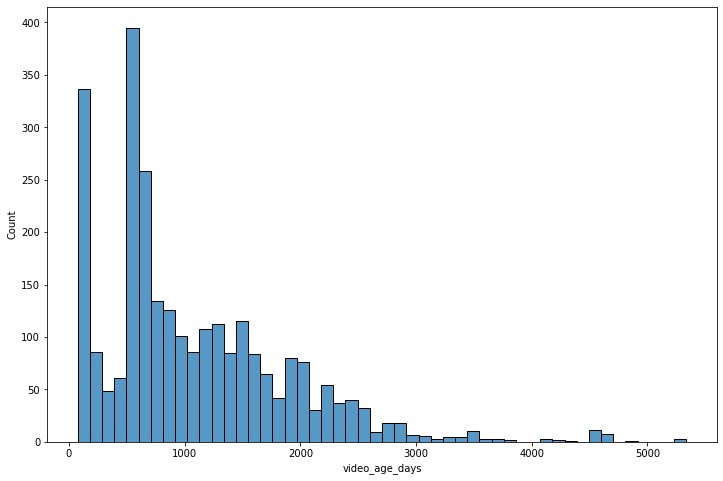

In [93]:
# Date age in days
df_videos['video_age_days'] = (datetime.now() - df_videos['publishedAt'].dt.tz_localize(None)).dt.days

# Visualization
plt.figure(figsize=(12,8))
sns.histplot(df_videos['video_age_days'], bins=50)
plt.show();

* Total Comments Likes

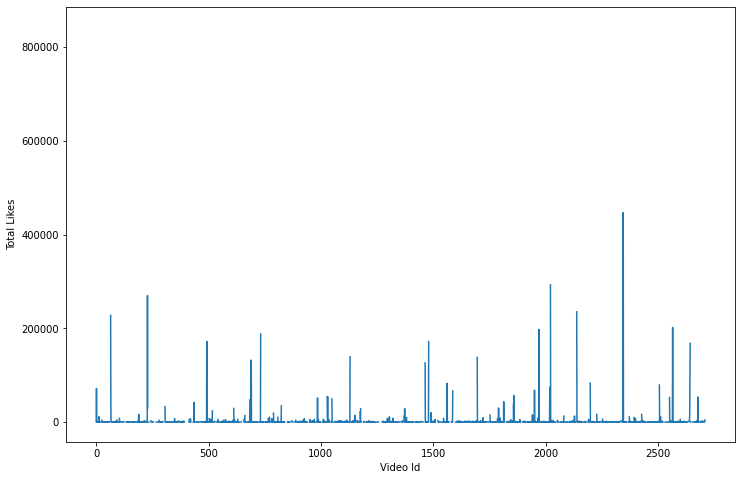

In [94]:
total_comments_likes = df_comments.groupby('video_id')['like_count'].sum().reset_index(name='total_comments_likes')
df_videos = df_videos.merge(total_comments_likes, on='video_id', how='left')

plt.figure(figsize=(12,8))
df_videos['total_comments_likes'].plot()
plt.ylabel('Total Likes')
plt.xlabel('Video Id')
plt.show();

* Weighted Sentiment

In [95]:
df_weighted_sentiment = pd.read_csv("../data/clean/df_videoid_emotionscore.csv/part-00000-1f04c136-e788-4899-92fa-efb423e4fcd4-c000.csv", header=None)
df_weighted_sentiment.rename(columns={0: 'video_id', 1: 'weighted_sentiment'}, inplace=True)

df_videos = df_videos.merge(df_weighted_sentiment, on='video_id', how='left')

Integrate `df_channel`relevant columns

In [96]:
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   channel_id        2010 non-null   object
 1   title             2010 non-null   object
 2   description       1857 non-null   object
 3   published_at      2010 non-null   object
 4   subscriber_count  2010 non-null   int64 
 5   video_count       2010 non-null   int64 
 6   view_count        2010 non-null   int64 
 7   region            1583 non-null   object
dtypes: int64(3), object(5)
memory usage: 125.8+ KB


In [97]:
# Add channel_age
df_channel['published_at'] = pd.to_datetime(df_channel['published_at'], format='mixed')
df_channel['channel_age_days'] = (datetime.now() - df_channel['published_at'].dt.tz_localize(None)).dt.days

In [98]:
df_videos = df_videos.merge(df_channel[['channel_id', 'subscriber_count', 'video_count', 'view_count', 'region', 'channel_age_days']], how='left', left_on='channelId', right_on='channel_id')

In [99]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   video_id              2711 non-null   object             
 1   title                 2711 non-null   object             
 2   channelId             2711 non-null   object             
 3   description           2535 non-null   object             
 4   publishedAt           2711 non-null   datetime64[ns, UTC]
 5   thumbnail_url         2711 non-null   object             
 6   tags                  2711 non-null   object             
 7   categoryId            2711 non-null   int64              
 8   viewCount             2711 non-null   int64              
 9   likeCount             2711 non-null   int64              
 10  commentCount          2711 non-null   int64              
 11  licensed              2711 non-null   bool               
 12  durati

Merge `df_channel`for better understanding of categories

In [100]:
df_categories.info()

# Add categories values to general dataframe
df_videos = df_videos.merge(df_categories, how='left', left_on='categoryId', right_on='id')

# Apply one-hot-encoding
df_videos = pd.concat([df_videos, pd.get_dummies(df_videos['category'], prefix='category')], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        31 non-null     int64 
 1   category  31 non-null     object
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes


Nummerical columns from `df_videos`

In [101]:
# List of nummerical relevant columns
numerical_columns = ['viewCount', 
                      'likeCount', 
                      'commentCount',
                      'total_comments_likes',
                      'licensed', 
                      'duration', 
                      'video_age_days', 
                      'weighted_sentiment',
                      'subscriber_count',
                      'video_count',
                      'view_count',
                      'channel_age_days',
                      'category_Autos & Vehicles',
                      'category_Comedy',
                      'category_Education',
                      'category_Entertainment',
                      'category_Film & Animation',
                      'category_Gaming',
                      'category_Howto & Style',
                      'category_Music',
                      'category_News & Politics',
                      'category_People & Blogs',
                      'category_Pets & Animals',
                      'category_Science & Technology',
                      'category_Sports',
                      'category_Travel & Events'
                      ]

df_videos[numerical_columns].iloc[:5]

,viewCount,likeCount,commentCount,total_comments_likes,licensed,duration,video_age_days,weighted_sentiment,subscriber_count,video_count,...,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Sports,category_Travel & Events
0,268029,8091,381,290.0,True,1499,551,0.631926,32600,143,...,False,False,False,False,False,False,False,False,False,False
1,3369370,35258,5948,71377.0,False,159,2650,-0.089505,18900,5,...,False,False,False,False,False,False,False,False,False,False
2,143984,2575,36,120.0,False,883,1299,0.275120,521000,2741,...,False,False,False,False,False,False,False,True,False,False
3,2430,270,3,0.0,True,44,575,0.603433,60700,909,...,False,False,False,False,False,False,False,True,False,False
4,113233,2030,84,279.0,True,1706,689,0.153131,5700000,1154,...,False,False,False,False,False,False,False,False,False,False


In [102]:
df_videos[numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   viewCount                      2711 non-null   int64  
 1   likeCount                      2711 non-null   int64  
 2   commentCount                   2711 non-null   int64  
 3   total_comments_likes           1767 non-null   float64
 4   licensed                       2711 non-null   bool   
 5   duration                       2711 non-null   int64  
 6   video_age_days                 2711 non-null   int64  
 7   weighted_sentiment             1767 non-null   float64
 8   subscriber_count               2711 non-null   int64  
 9   video_count                    2711 non-null   int64  
 10  view_count                     2711 non-null   int64  
 11  channel_age_days               2711 non-null   int64  
 12  category_Autos & Vehicles      2711 non-null   b

Address the Nan values

In [103]:
#Detect problematic videos
df_videos[(df_videos['total_comments_likes'].isna()) & (df_videos['commentCount'] > 0)][['video_id', 'commentCount', 'total_comments_likes']]

# Data of video 'ANIw1Mz1SRI' wasn't fetched correctly, so it will be removed from the dataset
df_videos = df_videos[df_videos['video_id'] != 'ANIw1Mz1SRI'].copy()

# Fill remaining total_comments_like values with 0
df_videos['total_comments_likes'].fillna(0, inplace=True)

# Fill Nan 'weighted_sentiment' with neutral sentiment = 0
df_videos['weighted_sentiment'].fillna(0, inplace=True)

/tmp/ipykernel_4749/2090152948.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_videos['total_comments_likes'].fillna(0, inplace=True)
/tmp/ipykernel_4749/2090152948.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [104]:
df_videos[numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2710 entries, 0 to 2710
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   viewCount                      2710 non-null   int64  
 1   likeCount                      2710 non-null   int64  
 2   commentCount                   2710 non-null   int64  
 3   total_comments_likes           2710 non-null   float64
 4   licensed                       2710 non-null   bool   
 5   duration                       2710 non-null   int64  
 6   video_age_days                 2710 non-null   int64  
 7   weighted_sentiment             2710 non-null   float64
 8   subscriber_count               2710 non-null   int64  
 9   video_count                    2710 non-null   int64  
 10  view_count                     2710 non-null   int64  
 11  channel_age_days               2710 non-null   int64  
 12  category_Autos & Vehicles      2710 non-null   bool  

In [105]:
df_videos.columns

Index(['video_id', 'title', 'channelId', 'description', 'publishedAt',
       'thumbnail_url', 'tags', 'categoryId', 'viewCount', 'likeCount',
       'commentCount', 'licensed', 'duration', 'caption', 'language',
       'video_age_days', 'total_comments_likes', 'weighted_sentiment',
       'channel_id', 'subscriber_count', 'video_count', 'view_count', 'region',
       'channel_age_days', 'id', 'category', 'category_Autos & Vehicles',
       'category_Comedy', 'category_Education', 'category_Entertainment',
       'category_Film & Animation', 'category_Gaming',
       'category_Howto & Style', 'category_Music', 'category_News & Politics',
       'category_People & Blogs', 'category_Pets & Animals',
       'category_Science & Technology', 'category_Sports',
       'category_Travel & Events'],
      dtype='object')

In [106]:
df_videos.to_csv('../data/clean_data/df_videos_modelling.csv', index=False)

# Standardization

In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

video_ids = df_videos['video_id']

videos_standardized = scaler.fit_transform(df_videos[numerical_columns])

df_videos_standardized = pd.DataFrame(videos_standardized, columns=numerical_columns)

df_videos_standardized = pd.concat([video_ids, df_videos_standardized], axis=1)

In [108]:
df_videos_standardized.head()

,video_id,viewCount,likeCount,commentCount,total_comments_likes,licensed,duration,video_age_days,weighted_sentiment,subscriber_count,...,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Sports,category_Travel & Events
0,qtlUwwtvuEg,-0.025962,-0.017246,0.021028,-0.096125,1.080740,0.059947,-0.632851,1.518879,-0.284323,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858
1,QaoDXYYtgK0,1.805809,0.379270,2.783664,2.748875,-0.925292,-0.342024,1.888623,-1.061388,-0.287248,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858
2,PqDwddEHswU,-0.099227,-0.097755,-0.150179,-0.102929,-0.925292,-0.124840,0.265702,0.242727,-0.180039,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,1.432411,-0.019213,-0.060858
3,B-Y7rnOa43w,-0.182834,-0.131398,-0.166555,-0.107731,1.080740,-0.376522,-0.604020,1.416969,-0.278323,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,1.432411,-0.019213,-0.060858
4,vyit-1zKsZ4,-0.117390,-0.105710,-0.126358,-0.096565,1.080740,0.122043,-0.467075,-0.193576,0.925785,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858


# Correlation Matrix

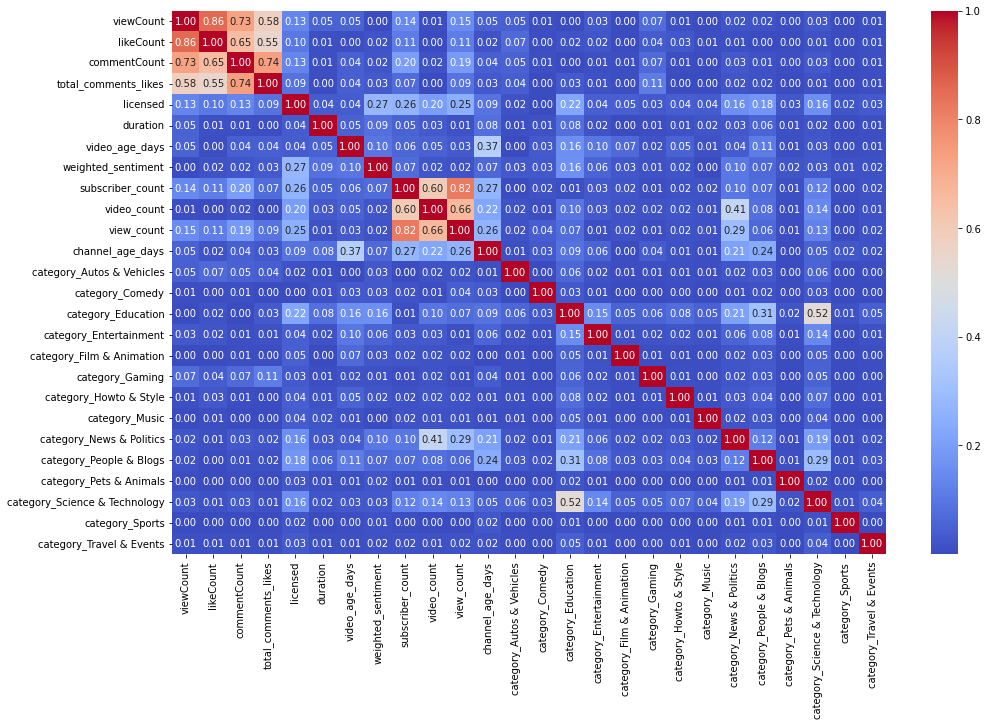

In [109]:
# Create correlation matrix
correlation_matrix = df_videos_standardized[numerical_columns].corr()

plt.figure(figsize=(16,10))
sns.heatmap(np.abs(correlation_matrix), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show();

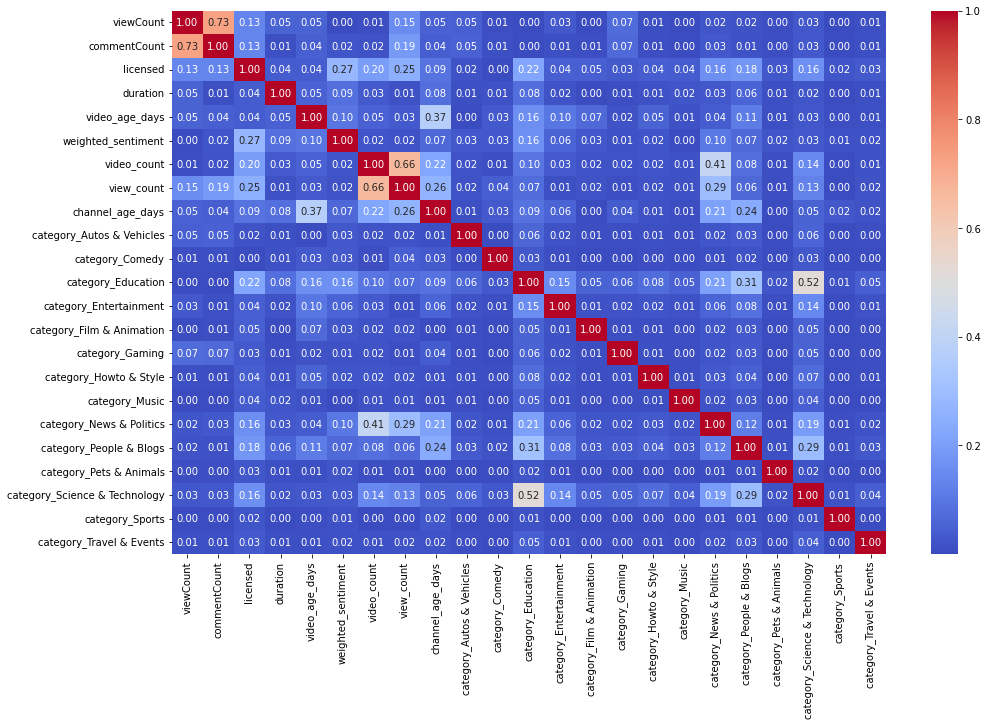

In [110]:
# Let's remove the highest correlated variables
high_correlation_variables = ['likeCount', 'total_comments_likes', 'subscriber_count']

# Drop the columns from standardize dataset
numerical_columns_clean = [column for column in numerical_columns if column not in high_correlation_variables]

# Re-plot the new correlation matrix
correlation_matrix = df_videos_standardized[numerical_columns_clean].corr()
plt.figure(figsize=(16,10))
sns.heatmap(np.abs(correlation_matrix), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show();

In [111]:
df_videos_standardized.dropna(inplace=True)

# K-Means Clustering for Relevance Labeling

In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(df_videos_standardized[numerical_columns_clean].dropna())

df_videos_standardized['cluster'] = kmeans.labels_

<Axes: xlabel='cluster'>

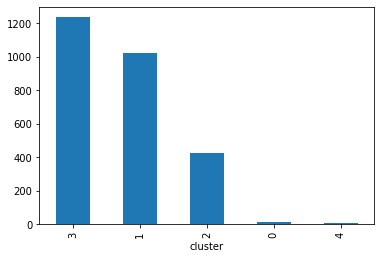

In [113]:
df_videos_standardized['cluster'].value_counts().plot(kind='bar')

In [114]:
# Cluster Analysis
# View the number of videos in each cluster
cluster_counts = df_videos_standardized['cluster'].value_counts()
print(cluster_counts)

# Analyze the characteristics of each cluster
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=numerical_columns_clean)
print(cluster_centers)

cluster
3    1236
1    1021
2     425
0      16
4      11
Name: count, dtype: int64
   viewCount  commentCount  licensed  duration  video_age_days  \
0   0.916832      0.895021  0.453855 -0.098854       -0.205423   
1  -0.023735     -0.035328 -0.247445 -0.030119       -0.076315   
2  -0.055351     -0.039020 -0.434404 -0.137473       -0.247864   
3   0.026942      0.031382  0.352012  0.076512        0.153403   
4  -0.006113     -0.036537 -0.560558 -0.312217       -0.220159   

   weighted_sentiment  video_count  view_count  channel_age_days  \
0            0.185043    -0.208137   -0.073839          0.494562   
1           -0.074942    -0.206747   -0.189585         -0.105593   
2           -0.178485    -0.217436   -0.205951         -0.530173   
3            0.121299     0.248186    0.221353          0.263459   
4           -0.059506    -0.222408   -0.217056         -0.110545   

   category_Autos & Vehicles  ...  category_Film & Animation  category_Gaming  \
0                  -0.079452 

In [115]:
from sklearn.decomposition import PCA

# Initialize the PCA model (for 2 components)
pca = PCA(n_components=2)

# Fit and transform the data
pca_components = pca.fit_transform(df_videos_standardized[numerical_columns_clean])

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])

# Add the cluster labels from K-Means to this DataFrame
df_pca['cluster'] = df_videos_standardized['cluster']

# Display the first few rows of the PCA DataFrame
print(df_pca.head())

       PCA1      PCA2  cluster
0  0.026205  1.735994      3.0
1  0.653754 -0.670930      1.0
2 -0.215960 -0.300760      1.0
3 -0.644546 -0.078829      1.0
4  0.556353  1.159718      3.0


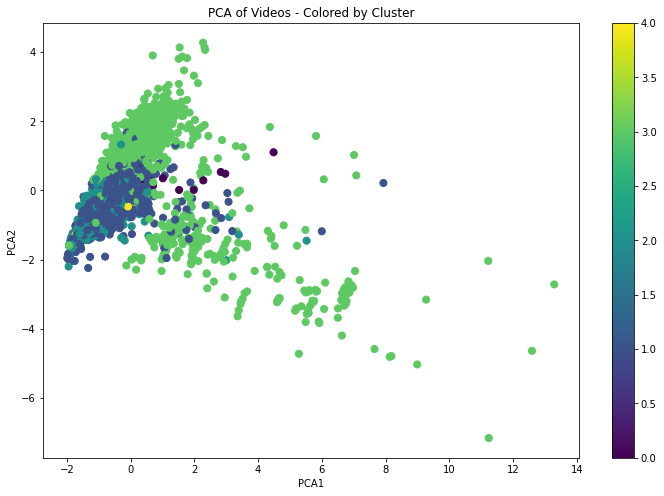

In [116]:
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

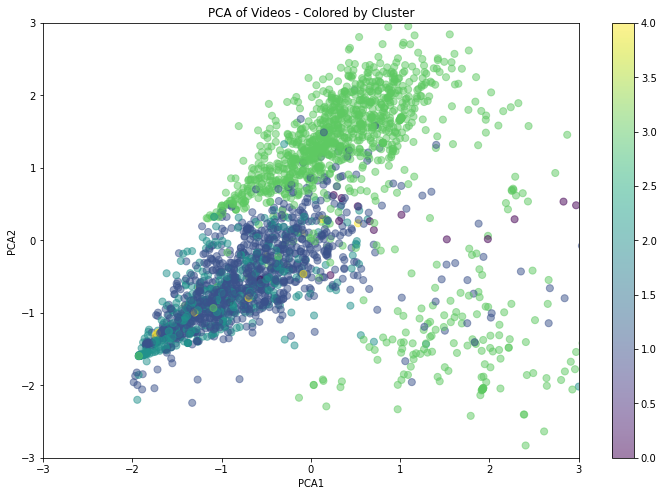

In [117]:
# Zooming
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50, alpha=0.5)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Zoom
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.savefig('../assets/video_clustering_kmeans.jpg', dpi=300)

plt.show()

# DBSCAN Clustering

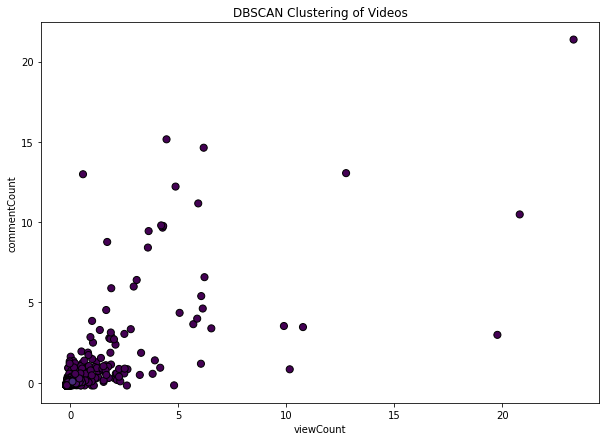

Estimated number of clusters: 32
Estimated number of noise points: 1237


In [118]:
from sklearn.cluster import DBSCAN

# eps: The maximum distance between two samples for them to be considered as in the same neighborhood
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_videos_standardized[numerical_columns_clean])

# Add the cluster labels to the DataFrame
df_videos_standardized['cluster'] = clusters

# Plotting the clustering result using the first two features
plt.figure(figsize=(10, 7))
plt.scatter(df_videos_standardized[numerical_columns_clean[0]], df_videos_standardized[numerical_columns_clean[1]], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Videos')
plt.xlabel(numerical_columns_clean[0])
plt.ylabel(numerical_columns_clean[1])
plt.show()

# Analyzing the results
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

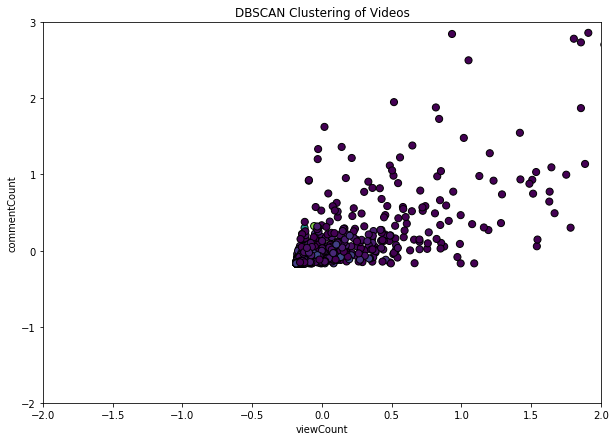

Estimated number of clusters: 27
Estimated number of noise points: 817


In [119]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pandas as pd

# Assuming df_videos_standardized and numerical_columns_clean are already defined
# Apply DBSCAN

X = df_videos_standardized[numerical_columns_clean]
min_samples = 5

dbscan = DBSCAN(eps=0.7, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
df_videos_standardized['cluster'] = clusters

# Plotting the clustering result using the first two features
plt.figure(figsize=(10, 7))
plt.scatter(X['viewCount'], X['commentCount'], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Videos')
plt.xlabel(numerical_columns_clean[0])
plt.ylabel(numerical_columns_clean[1])
# Zoom
plt.xlim(-2, 2)
plt.ylim(-2, 3)
plt.show()

# Analyzing the results
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


<Axes: xlabel='cluster'>

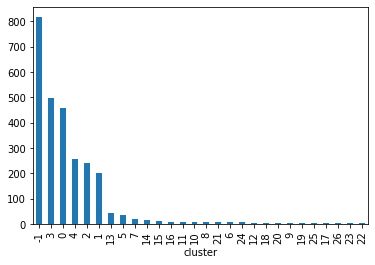

In [120]:
df_videos_standardized['cluster'].value_counts().plot(kind='bar')

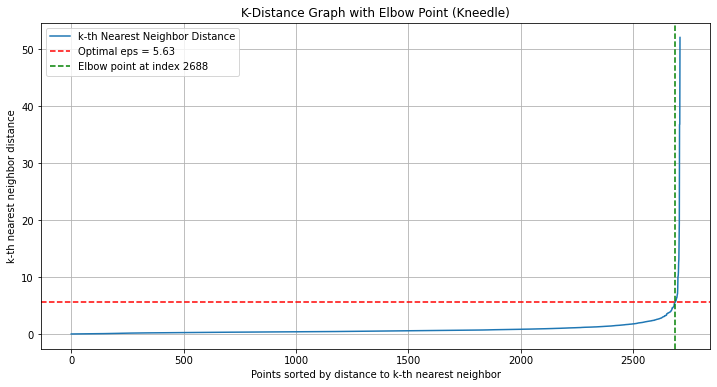

Optimal eps value: 5.6333050405798915


In [121]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Setting 'k' equal to min_samples - 1 (assuming min_samples is 4 for this example)
k = min_samples - 1

# Initialize NearestNeighbors with n_neighbors as 'k'
# Use the 'ball_tree' algorithm for efficient distance computation
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

# Find the distance to the k-th nearest neighbor for each point
# distances: Array of distances to k-th nearest neighbor
# indices: The indices of the k-th nearest neighbor in the dataset
distances, indices = nbrs.kneighbors(X)

# Sort the distances
sorted_distances = np.sort(distances[:, k-1], axis=0)

# Use the KneeLocator to find the elbow
kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
optimal_eps = sorted_distances[kneedle.elbow]

# Plotting the k-distance Graph
plt.figure(figsize=(12, 6))
plt.plot(sorted_distances, label='k-th Nearest Neighbor Distance')
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
plt.axvline(x=kneedle.elbow, color='g', linestyle='--', label=f'Elbow point at index {kneedle.elbow}')
plt.title('K-Distance Graph with Elbow Point (Kneedle)')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel('k-th nearest neighbor distance')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal eps value: {optimal_eps}')

In [122]:
# df_videos_standardized.to_csv('../data/clean_data/df_videos_standardized.csv', index=False)

# DBScan with PCA Components

In [123]:
from sklearn.decomposition import PCA

X = df_videos_standardized[numerical_columns_clean].copy()   

# Initialize the PCA model for 2 components
pca = PCA(n_components=3)

# Fit and transform the data using PCA
pca_components = pca.fit_transform(X)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2', 'PCA3'])

# Apply DBScan using one of the previously suggested combinations
dbscan_model = DBSCAN(eps=0.7, min_samples=10)
dbscan_labels = dbscan_model.fit_predict(X)

# Add the DBScan cluster labels to the PCA DataFrame
df_pca['cluster'] = dbscan_labels

# Display the first few rows of the PCA DataFrame
df_pca.head()

,PCA1,PCA2,PCA3,cluster
0,0.026205,1.735994,0.108431,1
1,0.653754,-0.670930,3.263749,-1
2,-0.215960,-0.300760,-0.319339,-1
3,-0.644546,-0.078829,0.134341,0
4,0.556353,1.159718,-0.239544,1


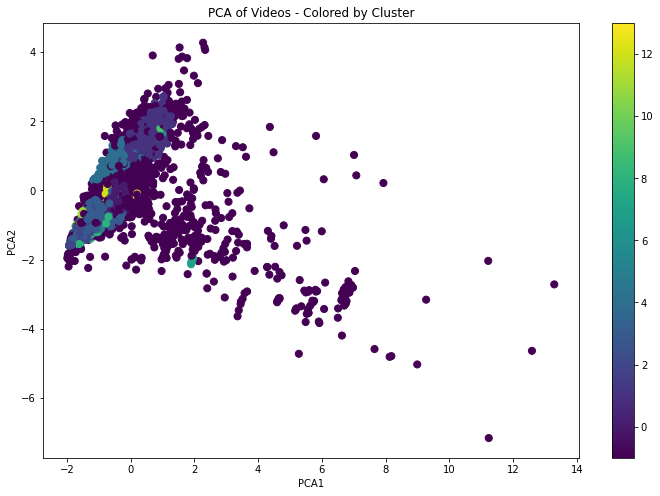

In [124]:
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# Hierarchical Clustering

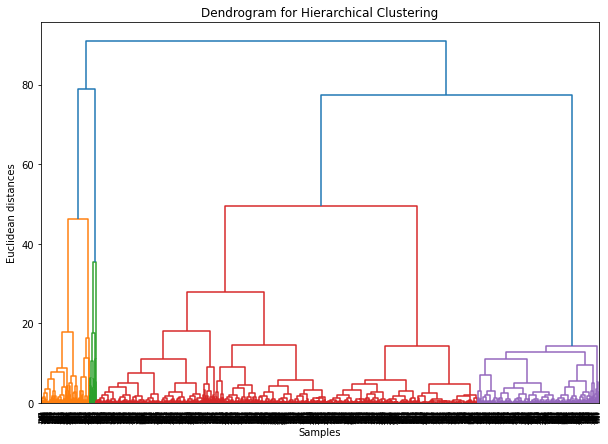

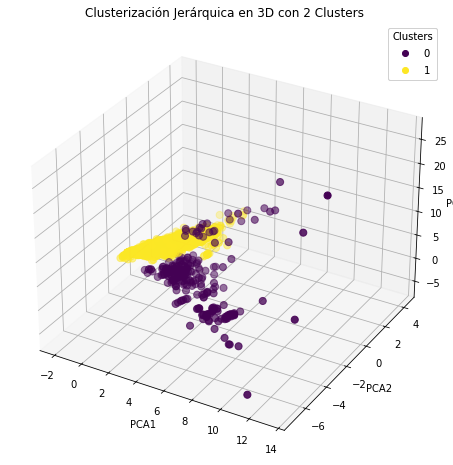

In [125]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

X_pca = pca_components

# Perform hierarchical clustering using Ward's method
linked = linkage(X_pca, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

n_clusters = 2
# Perform Agglomerative Clustering based on the dendrogram
# We can decide on the number of clusters based on the dendrogram, let's start with 2 clusters
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_labels = hierarchical_clustering.fit_predict(X_pca)

# Add the cluster labels to the PCA DataFrame
df_pca_hc = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca_hc['cluster'] = hc_labels

# Visualizar la clusterización en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos con los clusters obtenidos
scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c=hc_labels, cmap='viridis', s=50)

# Añadir etiquetas y título
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title(f'Clusterización Jerárquica en 3D con {n_clusters} Clusters')

# Añadir una barra de colores
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

<Axes: xlabel='cluster'>

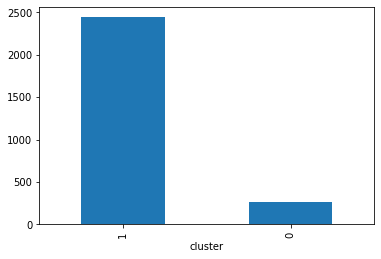

In [126]:
df_pca_hc['cluster'].value_counts().plot(kind='bar')

In [127]:
from sklearn.metrics import silhouette_score

# Assuming clusters are the labels assigned by the GMM model
sil_score = silhouette_score(X_pca, hc_labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.5972710500588296


# GMM Clustering

In [128]:
from sklearn.mixture import GaussianMixture

X_scaled = df_videos_standardized[numerical_columns_clean].copy()

# Define the GMM model
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)

# Fit the model to the data
gmm.fit(X_scaled)

# Predict the clusters for each data point
clusters = gmm.predict(X_scaled)

# Add the cluster labels to your dataframe
df_videos_standardized['GMM_cluster'] = clusters

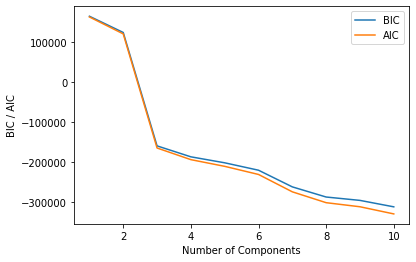

In [129]:
n_components = range(1, 11)
gmm_models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled) for n in n_components]

# Calculate BIC and AIC
bics = [model.bic(X_scaled) for model in gmm_models]
aics = [model.aic(X_scaled) for model in gmm_models]

# Plot the BIC and AIC scores
import matplotlib.pyplot as plt

plt.plot(n_components, bics, label='BIC')
plt.plot(n_components, aics, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC / AIC')
plt.legend()
plt.show()

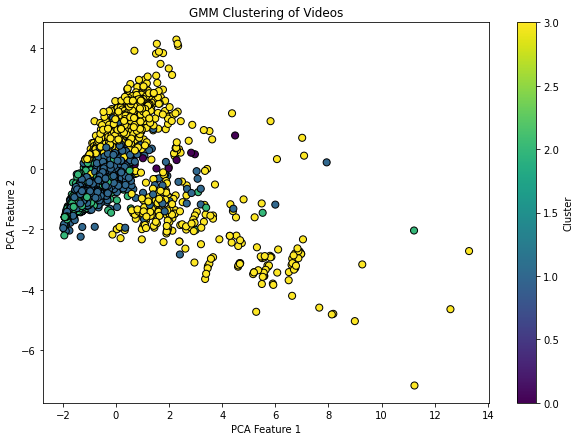

In [130]:
from sklearn.decomposition import PCA

# Reduce the data to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the GMM clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title('GMM Clustering of Videos')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()

<Axes: xlabel='GMM_cluster'>

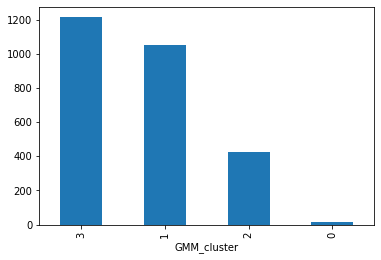

In [131]:
df_videos_standardized['GMM_cluster'].value_counts().plot(kind='bar')

In [132]:
from sklearn.metrics import silhouette_score

# Assuming clusters are the labels assigned by the GMM model
sil_score = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.21954179864207285


# CLUSTERING CHOICE

The cluster that best perfom is the K-Means algorithm

In [133]:
df_clusters = df_videos_standardized[['video_id', 'cluster']]
df_clusters.head(10)

,video_id,cluster
0,qtlUwwtvuEg,0
1,QaoDXYYtgK0,-1
2,PqDwddEHswU,3
3,B-Y7rnOa43w,1
4,vyit-1zKsZ4,0
5,MWNqE4z2C34,0
6,SWeQO2SEOmQ,2
7,pRC4M5Na3jM,2
8,ax-3m4GSa1c,-1
9,_8fDMmnDyYQ,2


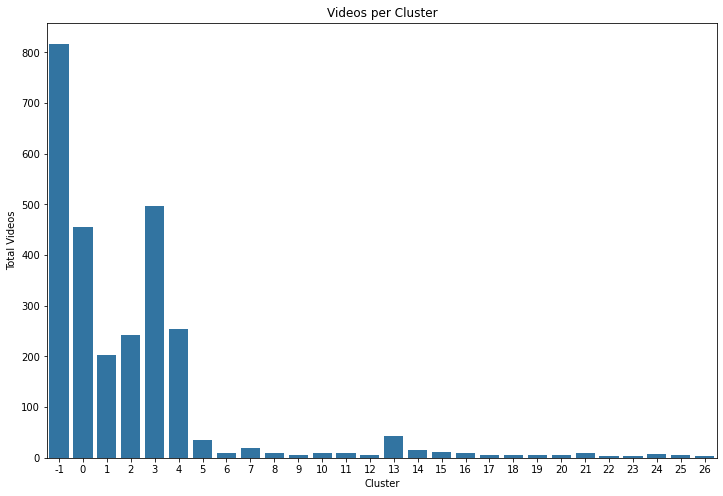

In [134]:
# Visualize the clustering
plt.figure(figsize=(12,8))
sns.countplot(data=df_clusters, x='cluster')
plt.xticks(rotation=0)
plt.title('Videos per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Videos')
plt.show()

In [135]:
# Save the dataframe
# df_clusters.to_csv('../data/clean_data/df_clusters.csv')